In [2]:
import os
import pandas as pd
import catboost as cb

In [4]:
train = pd.read_parquet("../data/processed/train-users.pq")
test = pd.read_parquet("../data/processed/test-users.pq")

In [21]:
def join_features(dataset: pd.DataFrame) -> pd.DataFrame:
    for feat_type in os.listdir("../data/features"):
        for features_file in os.listdir(f"../data/features/{feat_type}"):
            if not features_file.endswith(".pq"):
                continue
            
            features = pd.read_parquet(f"../data/features/{feat_type}/{features_file}")
            dataset = dataset.merge(features, how="left", on="user_id")
    return dataset

In [31]:
train_sex = join_features(train.loc[train["is_male"].notnull(), ["user_id", "is_male"]])

In [32]:
train_age = join_features(train.loc[train["age_bucket"] > 0, ["user_id", "age_bucket"]])

In [30]:
from sklearn.model_selection import train_test_split, KFold

In [35]:
COLS_TO_DROP_SEX = ["user_id", "is_male"]
COLS_TO_DROP_AGE = ["user_id", "age_bucket"]

CAT_FEATURES = [
    "top_city",
    "top_region",
    "device_manufacturer",
    "device_model",
    "top_part_of_day",
]

In [37]:
train_sex_pool = cb.Pool(
    train_sex.drop(columns=COLS_TO_DROP_SEX),
    label=train_sex["is_male"],
    cat_features=CAT_FEATURES,
)
train_age_pool = cb.Pool(
    train_age.drop(columns=COLS_TO_DROP_AGE),
    label=train_age["age_bucket"],
    cat_features=CAT_FEATURES,
)

In [40]:
%%time
cv_res_sex, cv_models_sex = cb.cv(
    pool=train_sex_pool,
    params={
        "eval_metric": "Logloss",
        "loss_function": "Logloss",
        "iterations": 5000,
        "early_stopping_rounds": 20,
        "random_seed": 777,
        "allow_writing_files": False,
    },
    folds=KFold(5, shuffle=True, random_state=777),
    verbose=50,
    return_models=True,
)

Training on fold [0/5]
0:	learn: 0.6922338	test: 0.6922108	best: 0.6922108 (0)	total: 79.8ms	remaining: 6m 38s
50:	learn: 0.6727733	test: 0.6725706	best: 0.6725706 (50)	total: 3.04s	remaining: 4m 55s
100:	learn: 0.6674852	test: 0.6677005	best: 0.6677005 (100)	total: 6.75s	remaining: 5m 27s
150:	learn: 0.6645223	test: 0.6652338	best: 0.6652338 (150)	total: 9.98s	remaining: 5m 20s
200:	learn: 0.6626337	test: 0.6638376	best: 0.6638376 (200)	total: 13.1s	remaining: 5m 13s
250:	learn: 0.6610202	test: 0.6627709	best: 0.6627709 (250)	total: 16.2s	remaining: 5m 7s
300:	learn: 0.6597841	test: 0.6619984	best: 0.6619984 (300)	total: 19.4s	remaining: 5m 3s
350:	learn: 0.6586928	test: 0.6613511	best: 0.6613511 (350)	total: 22.5s	remaining: 4m 58s
400:	learn: 0.6575671	test: 0.6606992	best: 0.6606992 (400)	total: 25.7s	remaining: 4m 54s
450:	learn: 0.6564233	test: 0.6601690	best: 0.6601690 (450)	total: 28.8s	remaining: 4m 50s
500:	learn: 0.6552016	test: 0.6595876	best: 0.6595876 (500)	total: 31.8s	r

In [43]:
model_sex = cb.sum_models(cv_models_sex)

In [44]:
%%time
cv_res_age, cv_models_age = cb.cv(
    pool=train_age_pool,
    params={
        "eval_metric": "MultiClass",
        "loss_function": "MultiClass",
        "iterations": 5000,
        "early_stopping_rounds": 20,
        "random_seed": 777,
        "allow_writing_files": False,
    },
    folds=KFold(5, shuffle=True, random_state=777),
    verbose=50,
    return_models=True,
)

Training on fold [0/5]
0:	learn: 1.7757709	test: 1.7760077	best: 1.7760077 (0)	total: 320ms	remaining: 26m 38s
50:	learn: 1.5035642	test: 1.5081441	best: 1.5081441 (50)	total: 13.3s	remaining: 21m 26s
100:	learn: 1.4649234	test: 1.4708974	best: 1.4708974 (100)	total: 25.9s	remaining: 20m 58s
150:	learn: 1.4519311	test: 1.4589383	best: 1.4589383 (150)	total: 38.7s	remaining: 20m 42s
200:	learn: 1.4444519	test: 1.4526160	best: 1.4526160 (200)	total: 51.8s	remaining: 20m 36s
250:	learn: 1.4394278	test: 1.4486627	best: 1.4486627 (250)	total: 1m 4s	remaining: 20m 25s
300:	learn: 1.4356010	test: 1.4459998	best: 1.4459998 (300)	total: 1m 17s	remaining: 20m 10s
350:	learn: 1.4322689	test: 1.4438287	best: 1.4438287 (350)	total: 1m 30s	remaining: 20m
400:	learn: 1.4292293	test: 1.4419790	best: 1.4419790 (400)	total: 1m 43s	remaining: 19m 47s
450:	learn: 1.4257021	test: 1.4397745	best: 1.4397745 (450)	total: 1m 56s	remaining: 19m 34s
500:	learn: 1.4222013	test: 1.4378871	best: 1.4378871 (500)	tot

In [45]:
model_age = cb.sum_models(cv_models_age)

In [56]:
test_features = join_features(test)
test_pred = test_features[["user_id"]].copy()
x_test = test_features.drop(columns="user_id")

test_pred["age"] = model_age.predict(x_test, prediction_type="Class").flatten()
test_pred["is_male"] = model_sex.predict(x_test, prediction_type="Probability")[:, 1]

In [58]:
test_pred.to_csv("../submissions/baseline-catboost.csv", index=False)

In [61]:
test_pred["age"].value_counts()

2    71386
3    56659
4     8593
1     5148
5     2916
6       22
Name: age, dtype: int64

In [53]:
model_sex.predict(x_test, prediction_type="Probability")

array([[0.02721936, 0.97278064],
       [0.87137567, 0.12862433],
       [0.01131024, 0.98868976],
       ...,
       [0.64869191, 0.35130809],
       [0.01035073, 0.98964927],
       [0.74140033, 0.25859967]])

In [64]:
exp_sex = cb.CatBoostClassifier(
    **{
        "loss_function": "Logloss",
        "iterations": 2000,
        "random_seed": 777,
        "allow_writing_files": False,
    }
)
exp_sex.fit(train_sex_pool, verbose=100)

Learning rate set to 0.05904
0:	learn: 0.6912279	total: 100ms	remaining: 3m 20s
100:	learn: 0.6627226	total: 6.67s	remaining: 2m 5s
200:	learn: 0.6581522	total: 12.9s	remaining: 1m 55s
300:	learn: 0.6542142	total: 18.9s	remaining: 1m 46s
400:	learn: 0.6511392	total: 25.1s	remaining: 1m 39s
500:	learn: 0.6484993	total: 31.2s	remaining: 1m 33s
600:	learn: 0.6461647	total: 37.3s	remaining: 1m 26s
700:	learn: 0.6440335	total: 43.4s	remaining: 1m 20s
800:	learn: 0.6419148	total: 49.6s	remaining: 1m 14s
900:	learn: 0.6398773	total: 55.7s	remaining: 1m 7s
1000:	learn: 0.6379718	total: 1m 1s	remaining: 1m 1s
1100:	learn: 0.6361015	total: 1m 8s	remaining: 55.7s
1200:	learn: 0.6343446	total: 1m 14s	remaining: 49.4s
1300:	learn: 0.6327361	total: 1m 20s	remaining: 43.4s
1400:	learn: 0.6310346	total: 1m 26s	remaining: 37.2s
1500:	learn: 0.6293968	total: 1m 33s	remaining: 30.9s
1600:	learn: 0.6278592	total: 1m 39s	remaining: 24.7s
1700:	learn: 0.6263816	total: 1m 45s	remaining: 18.5s
1800:	learn: 0.

In [65]:
exp_age = cb.CatBoostClassifier(
    **{
        "loss_function": "MultiClass",
        "iterations": 3000,
        "random_seed": 777,
        "allow_writing_files": False,
    }
)
exp_age.fit(train_age_pool, verbose=100)

Learning rate set to 0.041597
0:	learn: 1.7701072	total: 321ms	remaining: 16m 3s
100:	learn: 1.4543767	total: 27.8s	remaining: 13m 17s
200:	learn: 1.4381729	total: 56.1s	remaining: 13m 1s
300:	learn: 1.4294010	total: 1m 24s	remaining: 12m 35s
400:	learn: 1.4209619	total: 1m 52s	remaining: 12m 9s
500:	learn: 1.4148884	total: 2m 20s	remaining: 11m 42s
600:	learn: 1.4101193	total: 2m 49s	remaining: 11m 16s
700:	learn: 1.4059848	total: 3m 17s	remaining: 10m 48s
800:	learn: 1.4024470	total: 3m 46s	remaining: 10m 20s
900:	learn: 1.3989747	total: 4m 14s	remaining: 9m 52s
1000:	learn: 1.3959174	total: 4m 42s	remaining: 9m 24s
1100:	learn: 1.3928101	total: 5m 11s	remaining: 8m 57s
1200:	learn: 1.3897193	total: 5m 39s	remaining: 8m 28s
1300:	learn: 1.3869942	total: 6m 8s	remaining: 8m
1400:	learn: 1.3842616	total: 6m 36s	remaining: 7m 32s
1500:	learn: 1.3816337	total: 7m 4s	remaining: 7m 3s
1600:	learn: 1.3788601	total: 7m 32s	remaining: 6m 35s
1700:	learn: 1.3763835	total: 8m 1s	remaining: 6m 7

<Axes: >

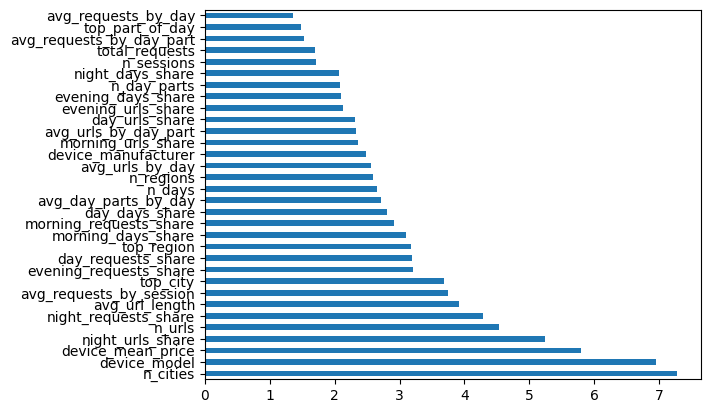

In [70]:
(
    pd.Series(exp_sex.feature_importances_, exp_sex.feature_names_)
    .sort_values(ascending=False)
    .plot.barh()
)

<Axes: >

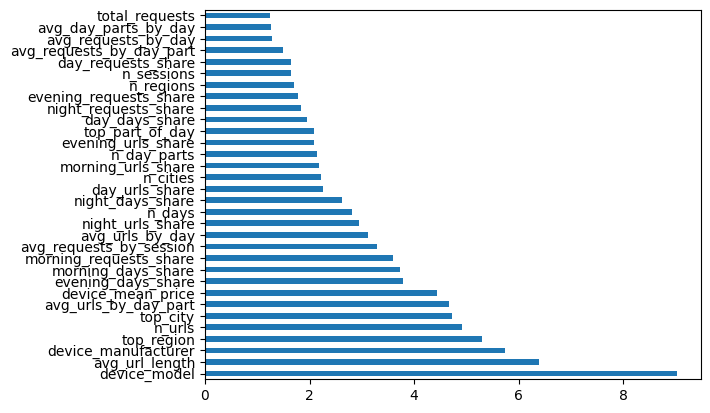

In [71]:
(
    pd.Series(exp_age.feature_importances_, exp_age.feature_names_)
    .sort_values(ascending=False)
    .plot.barh()
)

In [72]:
exp_sex.predict(train_sex_pool, prediction_type="Probability")[:, 1]

array([0.47288739, 0.50685592, 0.27778299, ..., 0.57631922, 0.55165928,
       0.67478737])

In [74]:
from sklearn import metrics as m

In [75]:
m.roc_auc_score(train_sex["is_male"], exp_sex.predict(train_sex_pool, prediction_type="Probability")[:, 1])

0.7160191440090247

In [76]:
2 * 0.71 - 1

0.41999999999999993

In [91]:
train_age["age_bucket"].to_numpy().astype(int)

array([2, 2, 3, ..., 2, 2, 6])

In [86]:
exp_age.predict(train_age_pool, prediction_type="Class").flatten()

array([3, 2, 2, ..., 2, 3, 3])

In [92]:
print(
    m.classification_report(
        train_age["age_bucket"].to_numpy().astype(int), 
        exp_age.predict(train_age_pool, prediction_type="Class").flatten(),
        target_names=['18-25','25-34', '35-44', '45-54', '55-65', '65+']
    )
)

              precision    recall  f1-score   support

       18-25       0.53      0.17      0.26     32641
       25-34       0.45      0.67      0.54     87270
       35-44       0.39      0.52      0.44     77486
       45-54       0.43      0.18      0.25     42442
       55-65       0.47      0.13      0.20     23580
         65+       0.84      0.02      0.04      5503

    accuracy                           0.43    268922
   macro avg       0.52      0.28      0.29    268922
weighted avg       0.45      0.43      0.39    268922



In [22]:
from __future__ import annotations
import pandas as pd

In [23]:
df = pd.read_csv("../data/processed/urls.csv", index_col=0).dropna().reset_index(drop=True)

In [25]:
def split_url(url: str) -> list[str]:
    parts = url.split(".")
    if parts[0] == "m":
        parts = parts[1:]
    return parts

In [26]:
df["url_parts"] = df["url_host"].apply(split_url)

In [27]:
df["url_parts"].apply(len).value_counts(normalize=True).cumsum()

2    0.617567
3    0.988892
4    0.996765
1    0.999224
5    0.999985
6    0.999995
7    1.000000
Name: url_parts, dtype: float64

In [29]:
df

,url_host,url_parts
0,yalta.ukrgo.com,"[yalta, ukrgo, com]"
1,mitrofanievskoe.ru,"[mitrofanievskoe, ru]"
2,zis18.ru,"[zis18, ru]"
3,170,[170]
4,xn--80abkduyveanm.xn--p1ai,"[xn--80abkduyveanm, xn--p1ai]"
...,...,...
199677,veronikahlebova.livejournal.com,"[veronikahlebova, livejournal, com]"
199678,electrotown.ru,"[electrotown, ru]"
199679,xn--g1ajus.xn--p1ai,"[xn--g1ajus, xn--p1ai]"
199680,business-and-banks.ru,"[business-and-banks, ru]"
